## 斜率:

斜率可以幫助我們看出 trend 的力道，特別注意到 y 軸的維度，因為每支股票的股價級距都不一樣，因此要選適當的級距  
而獲得斜率的方式是做 linear regression，公式為: $y = \beta_{1}\times x+ \epsilon$，注意到不能 regress through the origin，因為這代表迴歸線會穿越股價為0  

而因為股價的 delta 很大，所以要做 standarizaton，在此不用傳統的 ```Z-score```，而是用 ```Min-Max Scaling```，其公式為  
$$X_{new} = \frac{X_{i}-X_{min}}{X_{max}-X_{min}}$$

第一步: 安裝迴歸套件: ```conda install -c conda-forge statsmodels```

目標: 計算每五日的股價 (```Adj Close```) 之斜率

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import datetime as dt

讀入新套件:

In [3]:
import statsmodels.api as sm

In [4]:
ticker = "AAPL"
start = dt.datetime.today() - dt.timedelta(365)
end = dt.datetime.today()

In [5]:
ohlcv = yf.download(ticker, start, end)

[*********************100%***********************]  1 of 1 completed


In [22]:
def Slope(DF, n): # function to calculate slope for n consecutive days
     df = DF.copy()
     ser = df['Adj Close'] # only need close price to calculate slope
     ser = (ser - ser.min()) / (ser.max() - ser.min()) # standarization on y (stock price)

     x = np.array(range(len(ser)))
     x = (x - x.min()) / (x.max() - x.min()) # standarization on x (not actual date)

     slopes = [i*0 for i in range(n-1)]
     for j in range(n, len(ser)+1):
          y_scaled = ser[j-n:j] # n-5+(j-n):j
          x_scaled = x[:n]
          x_scaled = sm.add_constant(x_scaled) # need to add a constant so there will not be regressing through the origin

          model = sm.OLS(y_scaled, x_scaled)
          result = model.fit() 
          # summary = result.summary()
          slopes.append(result.params[-1]) # add the regression slope to slopes list
     slope_angle = np.rad2deg(np.arctan(np.array(slopes))) # 得出之 slope 要用 arctan() [tan 的反函數] 來得出 theta。得到 theta 後換回度數 (rad2deg)
     return np.array(slope_angle)
          

In [36]:
df = ohlcv.copy()

In [37]:
df['Slope'] = Slope(ohlcv, 5)

In [38]:
df['Slope']

Date
2020-01-28     0.000000
2020-01-29     0.000000
2020-01-30     0.000000
2020-01-31     0.000000
2020-02-03   -66.867072
                ...    
2021-01-20    19.011867
2021-01-21    80.499186
2021-01-22    83.957337
2021-01-25    84.654360
2021-01-26    82.986705
Name: Slope, Length: 252, dtype: float64

所得出的結果表示斜率的 $\theta$

In [41]:
df.shape

(252, 7)

array([[<AxesSubplot:xlabel='Date'>],
       [<AxesSubplot:xlabel='Date'>]], dtype=object)

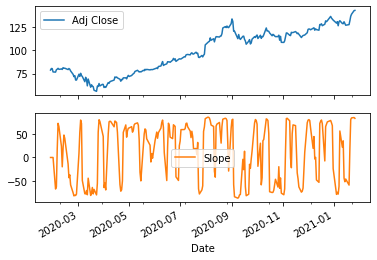

In [60]:
df.iloc[:, [4, 6]].plot(subplots=True, layout = (2, 1)) # 取出 Adj Close 與 Slope colum 並作圖

### ```Slope``` function 細拆

In [28]:
df = ohlcv.copy()
n = 5

ser = df['Adj Close'] # only need close price to calculate slope
ser = (ser - ser.min()) / (ser.max() - ser.min()) # standarization on y (stock price)

x = np.array(range(len(ser)))
x = (x - x.min()) / (x.max() - x.min()) # standarization on x (not actual date)

slopes = [i*0 for i in range(n-1)]

In [29]:
slopes

[0, 0, 0, 0]

In [30]:
x # standarize 後的 x

array([0.        , 0.00398406, 0.00796813, 0.01195219, 0.01593625,
       0.01992032, 0.02390438, 0.02788845, 0.03187251, 0.03585657,
       0.03984064, 0.0438247 , 0.04780876, 0.05179283, 0.05577689,
       0.05976096, 0.06374502, 0.06772908, 0.07171315, 0.07569721,
       0.07968127, 0.08366534, 0.0876494 , 0.09163347, 0.09561753,
       0.09960159, 0.10358566, 0.10756972, 0.11155378, 0.11553785,
       0.11952191, 0.12350598, 0.12749004, 0.1314741 , 0.13545817,
       0.13944223, 0.14342629, 0.14741036, 0.15139442, 0.15537849,
       0.15936255, 0.16334661, 0.16733068, 0.17131474, 0.1752988 ,
       0.17928287, 0.18326693, 0.187251  , 0.19123506, 0.19521912,
       0.19920319, 0.20318725, 0.20717131, 0.21115538, 0.21513944,
       0.21912351, 0.22310757, 0.22709163, 0.2310757 , 0.23505976,
       0.23904382, 0.24302789, 0.24701195, 0.25099602, 0.25498008,
       0.25896414, 0.26294821, 0.26693227, 0.27091633, 0.2749004 ,
       0.27888446, 0.28286853, 0.28685259, 0.29083665, 0.29482

### Alternative way:

In [ ]:
def slope(ser,n):
    '''function to calculate the slope of line connecting a point with n-previous point
     slope assumes a frame with 22 units in the x axis and span of min to max in y axis'''
    y_span = ser.max() - ser.min()
    x_span = 22
    slopes = [i*0 for i in range(n-1)]
    for i in range(n-1,len(ser)):
        y2 = ser[i]
        y1 = ser[i-n+1]
        slope = ((y2-y1)/y_span)/(n/x_span)
        slopes.append(slope)
    slope_angle = (np.rad2deg(np.arctan(np.array(slopes))))
    return np.array(slope_angle)

## Renko Chart (磚形圖)

> 磚形圖是技術指標的一種。磚形圖不考慮時間因素，只考慮價格變化，每當價格變化了一個設定的固定的點數後在圖表上就出現一個「磚塊」，或上升、或下降、也就是每一塊磚代表了一個固定點數。
---  
磚形圖最大的好處是過濾掉很多噪音，價格的趨勢和圖型等在圖表更容易被辯認出來，能更容易地進行交易。設定的點數越小，「磚塊」也越短，也就越能顯示價格變化的細節；設定的點數越大，「磚塊」也越長，則越能過濾掉噪音。  
---  
例如，假定當前美元/日元匯價為100，我們設定一個磚塊為50點。這種情況下，只有當匯價上漲至100.50時，行情圖上才會出現一個藍色（代表上漲）的磚塊，而只有當匯價下跌至99.50時，行情圖上才會出現一個紅色（代表下跌）的磚塊。如果匯價波動幅度不足50個基點，則不會顯示。

by [DailyFX](https://www.dailyfxasia.com/cn/feaarticle/20131017-5043.html)

因此，要做一個 Renko chart，需要資料與一個給定的(價格)間隔 (可以用 ```ATR``` 決定 delta 要多少)。

直接用 github 上有人寫好的 packages: ```pip install git+https://github.com/chillaranand/stocktrends```

In [74]:
from stocktrends import indicators

In [75]:
def ATR(DF, n):
    df = DF.copy()
    df["H-L"] = abs(df["High"] - df["Low"]) 
    df["H-PC"] = abs(df["High"] - df["Adj Close"].shift(1)) # 今天跳空上漲的情況
    df["L-PC"] = abs(df["Low"] - df["Adj Close"].shift(1)) # 今天跳空下跌
    # 取三者裡的最大者，且不忽略 NaN
    df["TR"] = df[ ["H-L", "H-PC", "L-PC"] ].max(axis=1, skipna=False)
    df["ATR"] = df["TR"].rolling(n).mean() # rolling 的天數自訂，通常用 20
    # 刪除暫時的 columns
    df = df.drop( ["H-L", "H-PC", "L-PC"], axis=1)
    return df

In [76]:
ohlcv.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Slope'], dtype='object')

In [77]:
ohlcv

,Open,High,Low,Close,Adj Close,Volume,Slope
Date,,,,,,,
2020-01-28,78.150002,79.599998,78.047501,79.422501,78.742477,162234000,0.000000
2020-01-29,81.112503,81.962502,80.345001,81.084999,80.390747,216229200,0.000000
2020-01-30,80.135002,81.022499,79.687500,80.967499,80.274246,126743200,0.000000
2020-01-31,80.232498,80.669998,77.072502,77.377502,76.714989,199588400,0.000000
2020-02-03,76.074997,78.372498,75.555000,77.165001,76.504311,173985600,-66.867072
...,...,...,...,...,...,...,...
2021-01-20,128.660004,132.490005,128.550003,132.029999,132.029999,104319500,19.011867
2021-01-21,133.800003,139.669998,133.589996,136.869995,136.869995,120529500,80.499186
2021-01-22,136.279999,139.850006,135.020004,139.070007,139.070007,114459400,83.957337


In [78]:
ohlcv.iloc[0, 0] # 第一 row，第一 column，其值為 78.15。故可推 Date 不是 column

78.1500015258789

In [79]:
ohlcv.index # 注意: 這些日期不是一個 column !!!

DatetimeIndex(['2020-01-28', '2020-01-29', '2020-01-30', '2020-01-31',
               '2020-02-03', '2020-02-04', '2020-02-05', '2020-02-06',
               '2020-02-07', '2020-02-10',
               ...
               '2021-01-12', '2021-01-13', '2021-01-14', '2021-01-15',
               '2021-01-19', '2021-01-20', '2021-01-21', '2021-01-22',
               '2021-01-25', '2021-01-26'],
              dtype='datetime64[ns]', name='Date', length=252, freq=None)

In [85]:
ohlcv2 = ohlcv.copy()
ohlcv2.reset_index(inplace=True) #  用 reset_index() 可以自動產生 index，並把原來的 index (即日期) 轉成 column
print(ohlcv2.columns)

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Slope'], dtype='object')


In [98]:
def Renko_DataFrame(DF):
    df2 = DF.copy()
    df2.reset_index(inplace=True) # 作者要求日期必須是一個 column，因此現在要找一組替代的 row index
    df2.columns = [i.lower() for i in df2.columns] # 此 library 之作者要求
    
    df3 = DF.copy() # 因 ATR function 內的格式非此 library 要求的格式，故再創一個 copy
    renko_df = Renko(df2) # 創建 Renko instance
    renko_df.brick_size = round(ATR(df3, 20)['ATR'][-1], 0) # brick size 選擇 20 日 ATR，並用最新一天的 ATR 當作 brick size，且取到整數位 (即小數點後 0 位)
    print("Renko's brick size: ", renko_df.brick_size)
    print(" ")

    renko_df.chart_type = indicators.Renko.PERIOD_CLOSE
    data = renko_df.get_ohlc_data()
    print(data)

    return data

In [99]:
renko = Renko_DataFrame(ohlcv)

Renko's brick size:  4.0
 
         date   open   high    low  close  uptrend
0  2020-01-28   72.0   76.0   72.0   76.0     True
1  2020-01-29   76.0   80.0   76.0   80.0     True
2  2020-02-27   76.0   76.0   72.0   72.0    False
3  2020-03-09   72.0   72.0   68.0   68.0    False
4  2020-03-12   68.0   68.0   64.0   64.0    False
5  2020-03-20   64.0   64.0   60.0   60.0    False
6  2020-04-13   64.0   68.0   64.0   68.0     True
7  2020-04-30   68.0   72.0   68.0   72.0     True
8  2020-05-08   72.0   76.0   72.0   76.0     True
9  2020-06-01   76.0   80.0   76.0   80.0     True
10 2020-06-09   80.0   84.0   80.0   84.0     True
11 2020-06-10   84.0   88.0   84.0   88.0     True
12 2020-07-06   88.0   92.0   88.0   92.0     True
13 2020-07-14   92.0   96.0   92.0   96.0     True
14 2020-07-31   96.0  100.0   96.0  100.0     True
15 2020-07-31  100.0  104.0  100.0  104.0     True
16 2020-08-03  104.0  108.0  104.0  108.0     True
17 2020-08-06  108.0  112.0  108.0  112.0     True
18 2

In [100]:
type(renko)

pandas.core.frame.DataFrame

In [104]:
renko.columns

Index(['date', 'open', 'high', 'low', 'close', 'uptrend'], dtype='object')

In [109]:
renko['uptrend'] = renko['uptrend'].astype(int)

array([[<AxesSubplot:>],
       [<AxesSubplot:>]], dtype=object)

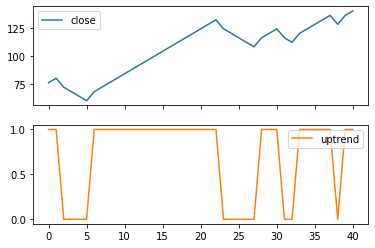

In [111]:
renko.iloc[:, [4, 5]].plot(subplots=True, layout=(2, 1))